In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from os.path import join as pjoin
from scipy.io import mmread
import scanpy as sc
import anndata
import squidpy as sq
from gpsa import VariationalGPSA, rbf_kernel
import torch
from IPython.display import display, clear_output
# import sys
# sys.path.append("../../../../paste")
# from src.paste import PASTE, visualization
# import scanpy as sc


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def rotate_90deg_counterclockwise(coords):
    y_coords_reflected = -coords[:, 1] - coords[:, 1].max()
    return np.vstack([y_coords_reflected, coords[:, 0]]).T

In [3]:
DATA_DIR = "../../../data/mouse_brain_slideseq/12_allMTXs_CCF/"



## Load data

In [4]:
gene_list = pd.read_table(pjoin(DATA_DIR, "01_Gene_List.txt"), header=None).values.squeeze()

metadata_slice1 = pd.read_table(pjoin(DATA_DIR, "MBASS_d1_metadata.tsv"))
metadata_slice2 = pd.read_table(pjoin(DATA_DIR, "MBASS_d3_metadata.tsv"))

barcodes_slice1 = pd.read_table(pjoin(DATA_DIR, "MBASS_d1_barcodes.txt"), header=None).values.squeeze()
barcodes_slice2 = pd.read_table(pjoin(DATA_DIR, "MBASS_d3_barcodes.txt"), header=None).values.squeeze()

data_sparse_slice1 = mmread(pjoin(DATA_DIR, "MBASS_d1_matrix.mtx"))
data_sparse_slice2 = mmread(pjoin(DATA_DIR, "MBASS_d3_matrix.mtx"))

data_slice1 = pd.DataFrame(data_sparse_slice1.toarray(), index=gene_list, columns=barcodes_slice1)
data_slice2 = pd.DataFrame(data_sparse_slice2.toarray(), index=gene_list, columns=barcodes_slice2)

In [7]:
# data_slice1.iloc[:, 0][:10]
"Pcp4" in data_slice1.index.values

True

## Manually rotate one slice so they have same orientation

In [46]:
rotated_coords_slice1 = rotate_90deg_counterclockwise(rotate_90deg_counterclockwise(rotate_90deg_counterclockwise(metadata_slice1[["Original_x", "Original_y"]].values)))
X_slice1 = rotated_coords_slice1[~metadata_slice1.isOutsideCCF]
X_slice2 = metadata_slice2.loc[~metadata_slice2.isOutsideCCF, ["Original_x", "Original_y"]].values

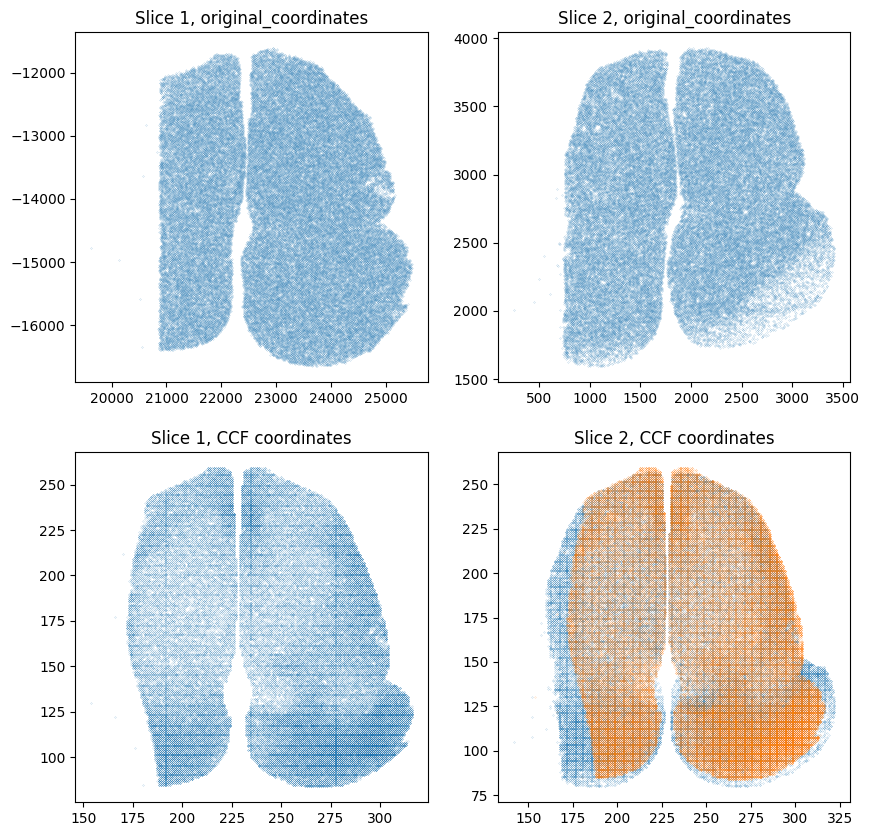

In [64]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(X_slice1[:, 0], X_slice1[:, 1], s=.01)
plt.title("Slice 1, original_coordinates")
# plt.axis("off")

plt.subplot(222)
plt.scatter(X_slice2[:, 0], X_slice2[:, 1], s=.01)
# plt.scatter(X_slice1[:, 0], X_slice1[:, 1], s=.01)
plt.title("Slice 2, original_coordinates")
# plt.axis("off")

plt.subplot(223)
X_slice1_ccf = metadata_slice1[["CCF3D_z", "CCF3D_y"]].values
X_slice1_ccf = X_slice1_ccf[~metadata_slice1.isOutsideCCF]
plt.scatter(X_slice1_ccf[:, 0], X_slice1_ccf[:, 1], s=.01)
plt.title("Slice 1, CCF coordinates")
# plt.axis("off")

plt.subplot(224)
X_slice2_ccf = metadata_slice2[["CCF3D_z", "CCF3D_y"]].values
X_slice2_ccf = X_slice2_ccf[~metadata_slice2.isOutsideCCF]
plt.scatter(X_slice2_ccf[:, 0], X_slice2_ccf[:, 1], s=.01)
plt.scatter(X_slice1_ccf[:, 0], X_slice1_ccf[:, 1], s=.01)
plt.title("Slice 2, CCF coordinates")
# plt.axis("off")
plt.show()

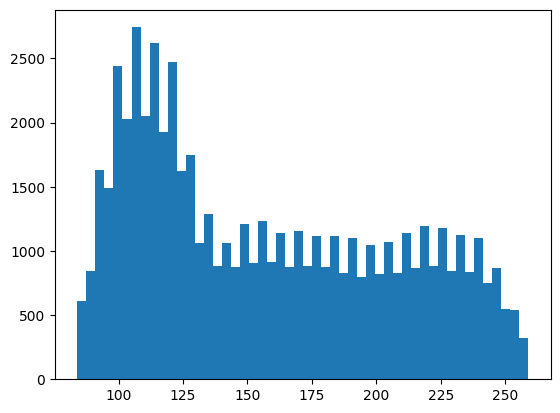

In [7]:
plt.hist(X_slice1_ccf[:, 1], 50)
plt.show()

## Filter for spots inside the tissue and create AnnData objects

In [8]:
n_spots = 5_000
n_genes = 10_000

in_slice_idx = np.where(~metadata_slice1.isOutsideCCF.values)[0]
in_slice_idx = np.random.choice(in_slice_idx, size=n_spots, replace=False)

X_slice1 = rotated_coords_slice1[in_slice_idx]
Y_slice1 = data_slice1.transpose().iloc[in_slice_idx, :n_genes]
Y_slice1 = Y_slice1.loc[:, Y_slice1.sum(0) > 0]
anndata_slice1 = anndata.AnnData(Y_slice1)
anndata_slice1.obsm['spatial'] = X_slice1

in_slice_idx = np.where(~metadata_slice2.isOutsideCCF.values)[0]
in_slice_idx = np.random.choice(in_slice_idx, size=n_spots, replace=False)

X_slice2 = metadata_slice2[["Original_x", "Original_y"]].values[in_slice_idx]
Y_slice2 = data_slice2.transpose().iloc[in_slice_idx, :n_genes]
Y_slice2 = Y_slice2.loc[:, Y_slice2.sum(0) > 0]
anndata_slice2 = anndata.AnnData(Y_slice2)
anndata_slice2.obsm['spatial'] = X_slice2

<ipython-input-8-94af5dade05a>:10: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata_slice1 = anndata.AnnData(Y_slice1)
<ipython-input-8-94af5dade05a>:19: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata_slice2 = anndata.AnnData(Y_slice2)


## Compute spatial autocorrelation (Moran's I) for each gene

In [9]:
sq.gr.spatial_neighbors(anndata_slice1)
sq.gr.spatial_autocorr(
    anndata_slice1,
    mode="moran",
)

sq.gr.spatial_neighbors(anndata_slice2)
sq.gr.spatial_autocorr(
    anndata_slice2,
    mode="moran",
)

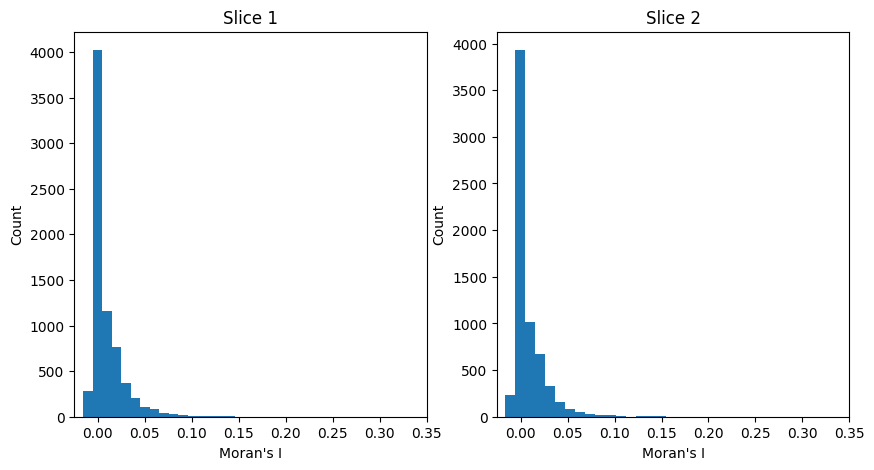

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
moran_genenames_sorted_slice1 = anndata_slice1.uns["moranI"].index.values #.astype(int)
plt.hist(anndata_slice1.uns["moranI"].I.values, 30)
plt.xlabel("Moran's I")
plt.ylabel("Count")
plt.title("Slice 1")
plt.xlim([-0.025, 0.35])

plt.subplot(122)
moran_genenames_sorted_slice2 = anndata_slice2.uns["moranI"].index.values #.astype(int)
plt.hist(anndata_slice2.uns["moranI"].I.values, 30)
plt.xlabel("Moran's I")
plt.ylabel("Count")
plt.title("Slice 2")
plt.xlim([-0.025, 0.35])
plt.show()

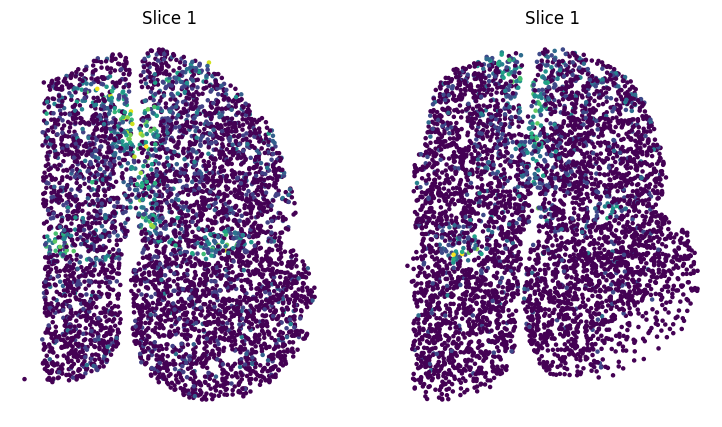

In [13]:
gene_idx_to_plot = 0

plt.figure(figsize=(14, 5))
plt.subplot(131)
plt.scatter(anndata_slice1.obsm["spatial"][:, 0], anndata_slice1.obsm["spatial"][:, 1], c=np.log(anndata_slice1[:, moran_genenames_sorted_slice1[gene_idx_to_plot]].X.squeeze() + 1), s=5)
plt.title("Slice 1")
plt.axis("off")

plt.subplot(132)
plt.scatter(anndata_slice2.obsm["spatial"][:, 0], anndata_slice2.obsm["spatial"][:, 1], c=np.log(anndata_slice2[:, moran_genenames_sorted_slice1[gene_idx_to_plot]].X.squeeze() + 1), s=5)
plt.title("Slice 1")
plt.axis("off")

# plt.subplot(133)
# plt.scatter(X1[:, 0], X1[:, 1], s=5)
# plt.scatter(X2[:, 0], X2[:, 1], s=5)
# plt.axis("off")
plt.show()

In [14]:
genenames_to_keep = np.intersect1d(moran_genenames_sorted_slice1[:30], moran_genenames_sorted_slice2[:30])
anndata_slice1 = anndata_slice1[:, genenames_to_keep]
anndata_slice2 = anndata_slice2[:, genenames_to_keep]

## Start alignment

In [15]:
def scale_spatial_coords(X, max_val=10.0):
    X = X - X.min(0)
    X = X / X.max(0)
    return X * max_val

In [16]:
n_views = 2
anndata_all_slices = anndata_slice1.concatenate(anndata_slice2)
n_samples_list = [anndata_all_slices[anndata_all_slices.obs.batch == str(ii)].shape[0] for ii in range(n_views)]

X1 = np.array(anndata_all_slices[anndata_all_slices.obs.batch == "0"].obsm["spatial"])
X2 = np.array(anndata_all_slices[anndata_all_slices.obs.batch == "1"].obsm["spatial"])
Y1 = np.log(np.array(anndata_all_slices[anndata_all_slices.obs.batch == "0"].X) + 1)
Y2 = np.log(np.array(anndata_all_slices[anndata_all_slices.obs.batch == "1"].X) + 1)

Y1 = (Y1 - Y1.mean(0)) / Y1.std(0)
Y2 = (Y2 - Y2.mean(0)) / Y2.std(0)

X1 = scale_spatial_coords(X1)
X2 = scale_spatial_coords(X2)
X = np.concatenate([X1, X2])
Y = np.concatenate([Y1, Y2])

view_idx = [
    np.arange(X1.shape[0]),
    np.arange(X1.shape[0], X1.shape[0] + X2.shape[0]),
]

x = torch.from_numpy(X).float().clone()
y = torch.from_numpy(Y).float().clone()


data_dict = {
    "expression": {
        "spatial_coords": x,
        "outputs": y,
        "n_samples_list": n_samples_list,
    }
}

/Users/andrewjones/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [109]:
n_spatial_dims = 2
m_X_per_view = 50
m_G = 50
N_LATENT_GPS = {"expression": None}
N_EPOCHS = 400
PRINT_EVERY = 50

In [110]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VariationalGPSA(
    data_dict,
    n_spatial_dims=n_spatial_dims,
    m_X_per_view=m_X_per_view,
    m_G=m_G,
    data_init=True,
    minmax_init=False,
    grid_init=False,
    n_latent_gps=N_LATENT_GPS,
    mean_function="identity_fixed",
#     mean_function="identity_initialized",
    kernel_func_warp=rbf_kernel,
    kernel_func_data=rbf_kernel,
    fixed_warp_kernel_variances=np.ones(n_views) * 1e-2,
    # fixed_warp_kernel_lengthscales=np.ones(n_views) * 10,
    fixed_view_idx=0,
).to(device)

view_idx, Ns, _, _ = model.create_view_idx_dict(data_dict)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

def train(model, loss_fn, optimizer):
    model.train()

    # Forward pass
    G_means, G_samples, F_latent_samples, F_samples = model.forward(
        X_spatial={"expression": x}, view_idx=view_idx, Ns=Ns, S=5
    )

    # Compute loss
    loss = loss_fn(data_dict, F_samples)

    # Compute gradients and take optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), G_means

Iter: 399        LL -3.128e+05


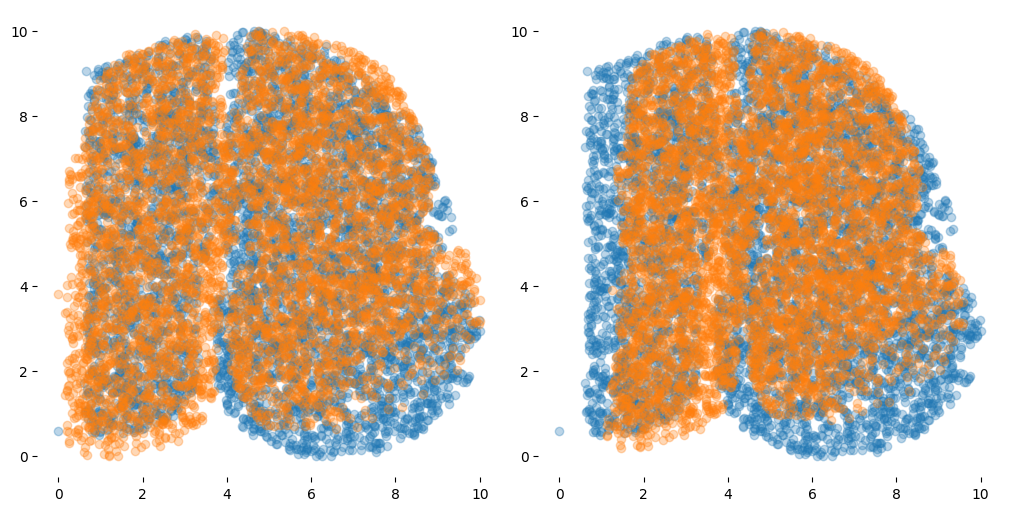

In [111]:
# Set up figure.
fig = plt.figure(figsize=(10, 5), facecolor="white", constrained_layout=True)
ax1 = fig.add_subplot(121, frameon=False)
ax2 = fig.add_subplot(122, frameon=False)
ax1.invert_yaxis()
ax2.invert_yaxis()
# plt.show(block=False)
loss_trace = []

for t in range(N_EPOCHS):
    loss, G_means = train(model, model.loss_fn, optimizer)
    loss_trace.append(loss)

    if t % PRINT_EVERY == 0 or t == N_EPOCHS - 1:
        print("Iter: {0:<10} LL {1:1.3e}".format(t, -loss))

        aligned_coords = G_means["expression"].detach().numpy()
        aligned_coords_slice1 = aligned_coords[view_idx["expression"][0]]
        aligned_coords_slice2 = aligned_coords[view_idx["expression"][1]]
        
        ax1.cla()
        ax2.cla()
        
        ax1.scatter(X1[:, 0], X1[:, 1], alpha=0.3)
        ax1.scatter(X2[:, 0], X2[:, 1], alpha=0.3)

        ax2.scatter(X1[:, 0], X1[:, 1], alpha=0.3)
        ax2.scatter(
            aligned_coords_slice2[:, 0],
            aligned_coords_slice2[:, 1],
            alpha=0.3,
        )

#         ax1.invert_yaxis()
#         ax2.invert_yaxis()

#         plt.draw()
        display(fig)
    
        clear_output(wait = True)
        plt.pause(1 / 60.0)
plt.close()

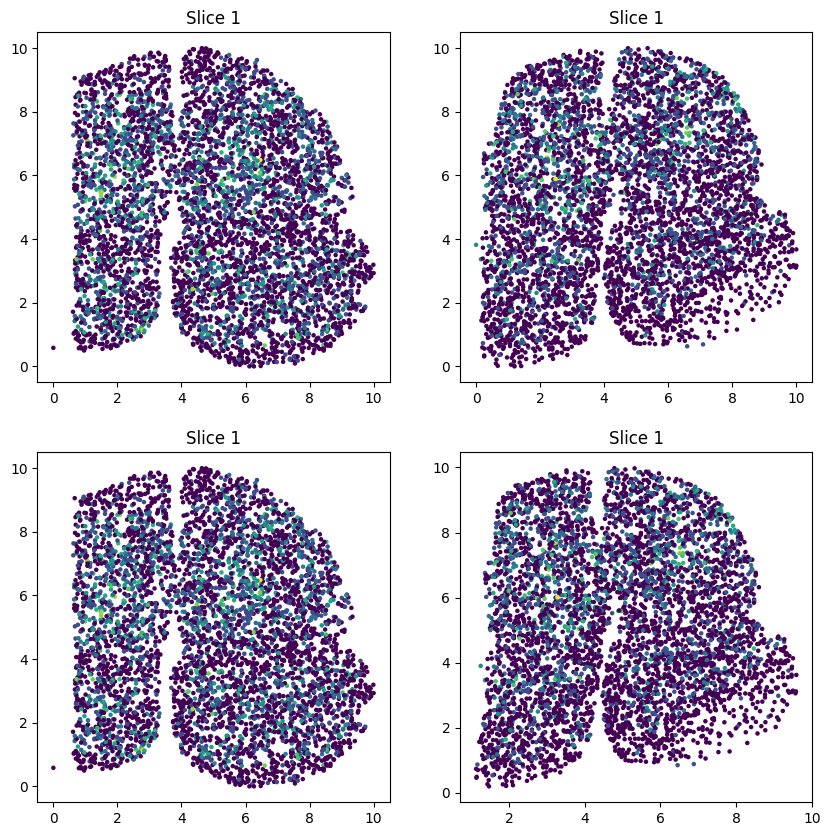

In [112]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(X1[:, 0], X1[:, 1], c=Y1[:, 0], s=5)
plt.title("Slice 1")
# plt.axis("off")

plt.subplot(222)
plt.scatter(X2[:, 0], X2[:, 1], c=Y2[:, 0], s=5)
plt.title("Slice 1")
# plt.axis("off")

plt.subplot(223)
plt.scatter(aligned_coords_slice1[:, 0], aligned_coords_slice1[:, 1], c=Y1[:, 0], s=5)
plt.title("Slice 1")
# plt.axis("off")

plt.subplot(224)
plt.scatter(aligned_coords_slice2[:, 0], aligned_coords_slice2[:, 1], c=Y2[:, 0], s=5)
plt.title("Slice 1")
# plt.axis("off")
plt.show()

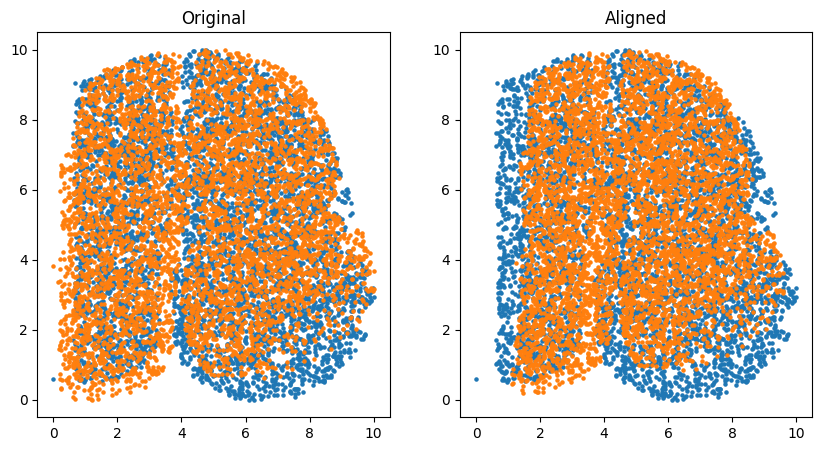

In [113]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X1[:, 0], X1[:, 1], s=5)
plt.scatter(X2[:, 0], X2[:, 1], s=5)
plt.title("Original")

plt.subplot(122)
plt.scatter(aligned_coords_slice1[:, 0], aligned_coords_slice1[:, 1], s=5)
plt.scatter(aligned_coords_slice2[:, 0], aligned_coords_slice2[:, 1], s=5)
plt.title("Aligned")
plt.show()






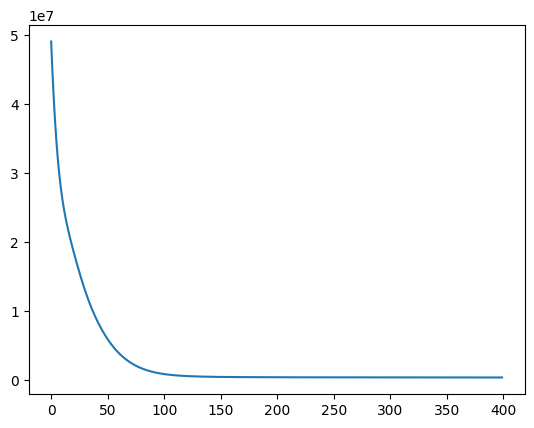

In [114]:
plt.plot(loss_trace)
plt.show()
